In [1]:
!pip install -q lion-pytorch

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lion_pytorch import Lion
import torchvision as tv
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def plot_images(imgs, n_rows=8):    
    imgs = tv.utils.make_grid(imgs, n_rows, padding=4)
    plt.figure(figsize=(12, 12))
    plt.imshow(imgs.permute(1, 2, 0))
    plt.show()

In [5]:
class ImagePairDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size):
        super().__init__()
        self.img_paths = [
            os.path.join(img_dir, path)
            for path in os.listdir(img_dir)
            if path.endswith('.jpg')
            or path.endswith('.jpeg')
            or path.endswith('.png')
        ]
        self.label_paths = [
            os.path.join(label_dir, path)
            for path in os.listdir(label_dir)
            if path.endswith('.jpg')
            or path.endswith('.jpeg')
            or path.endswith('.png')
        ]
        assert len(self.img_paths) == len(self.label_paths)
        self.resize = transforms.Resize(img_size, antialias=True)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = tv.io.read_image(self.img_paths[index])
        img = self.resize(img) / 255.0
        label = tv.io.read_image(self.label_paths[index])
        label = self.resize(label)[0] / 255.0
        return img, label.round()

In [6]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.sa = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding='same'),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        x_compress = torch.cat([
            x.max(dim=1, keepdim=True)[0],
            x.mean(dim=1, keepdim=True)
        ], dim=1)
        x_out = self.sa(x_compress)
        scale = torch.sigmoid(x_out)
        return x * scale

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [8]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels,
                                         kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.deconv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout=None):
        super().__init__()
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.conv_block_1 = ConvBlock(in_channels, out_channels, kernel_size, padding='same')
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.norm_2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)
        if dropout:
            self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        skip = self.res_conv(x)
        x = self.conv_block_1(x)
        x = self.conv_2(x) + skip
        x = self.norm_2(x)
        x = self.relu(x)
        if hasattr(self, 'dropout'):
            x = self.dropout(x)
        return x

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout=None):
        super().__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, kernel_size, dropout)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.maxpool(x)
        x = self.res_block(x)
        return x

In [11]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout=None):
        super().__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, kernel_size, dropout)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    def forward(self, x):        
        x = self.res_block(x)
        x = self.upsample(x)
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.downsample = nn.ModuleList([
            ResidualBlock(3, 64, 3, 0.1),
            DownBlock(64, 128, 3, 0.1),
            DownBlock(128, 256, 3, 0.1),
            DownBlock(256, 512, 3, 0.1),
            DownBlock(512, 1024, 3, 0.1),
        ])
        
        self.upsample = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear'),
            UpBlock(1024 + 512, 512, 3, 0.1),
            UpBlock(512 + 256, 256, 3, 0.1),
            UpBlock(256 + 128, 128, 3, 0.1),
        ])
        
        self.last_blocks = nn.ModuleList([
            ResidualBlock(128 + 64, 64, 3, 0.1),
            nn.Conv2d(64, 1, 3, padding='same'),
            nn.Sigmoid(),
        ])
        
        self.sa = SpatialAttention()
    
    def forward(self, x):
        skips = []
        for block in self.downsample:
            x = block(x)
            skips.append(x)
        x = self.sa(x)
        skips = reversed(skips[:-1])
        for block, skip in zip(self.upsample, skips):
            x = block(x)
            x = torch.concat([x, skip], dim=1)
        for block in self.last_blocks:
            x = block(x)
        return x.squeeze()

In [13]:
@torch.no_grad()
def f1_score(y_pred, y_true):
    epsilon = 1e-8
    y_pred = y_pred.round()
    tp = ((y_true == 1) & (y_pred == 1)).float().sum()
    fp = ((y_true == 0) & (y_pred == 1)).float().sum()
    fn = ((y_true == 1) & (y_pred == 0)).float().sum()
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1_score = 2 * ((precision * recall) / (precision + recall + epsilon))
    return f1_score

@torch.no_grad()
def compute_acc(pred, labels):
    return (pred.round() == labels).sum() / labels.numel()

In [14]:
@torch.no_grad()
def evaluate_batch(images, labels):
    net.eval()
    pred = net(images)
    loss = F.binary_cross_entropy(pred, labels)
    acc = compute_acc(pred, labels)
    f1 = f1_score(pred, labels)
    return loss.item(), acc.item(), f1.item()

@torch.no_grad()
def evaluate(val_data_loader):
    net.eval()
    N = len(val_data_loader)
    loss = 0
    acc = 0
    f1 = 0
    for images, labels in val_data_loader:
        loss_batch, acc_batch, f1_batch = evaluate_batch(
            images.to(device),
            labels.to(device)
        )
        loss += loss_batch / N
        acc += acc_batch / N
        f1 += f1_batch / N
    return loss, acc, f1

In [15]:
@torch.no_grad()
def test(images, labels):
    net.eval()
    loss, acc, f1 = evaluate_batch(images, labels)
    print(f'loss: {loss:.8f} - acc: {acc:.8f} - f1 score: {f1:.8f}')
    mask_pred = net(images)
    
    images = images.cpu()
    labels = labels.cpu()
    mask_pred = mask_pred.cpu()
    
    hm = torch.tensor(plt.cm.jet(mask_pred)[..., :3])
    hm = hm.permute(0, 3, 1, 2)
    
    plot_images(images)
    plot_images(images * 0.4 + 0.6 * hm)
    
    print('Predicted masks:')
    plot_images(mask_pred.unsqueeze(1))
    print('Ground truth:')
    plot_images(labels.unsqueeze(1))

In [16]:
net = UNet()
net = nn.DataParallel(net)
net.to(device)
optimizer = Lion(
    net.parameters(),
    lr=2e-4,
    weight_decay=1e-2
)

In [17]:
train_ds = ImagePairDataset(
    img_dir='data/Kvasir_SEG_Training_880/Kvasir_SEG_Training_880/image',
    label_dir='data/Kvasir_SEG_Training_880/Kvasir_SEG_Training_880/mask',
    img_size=(128, 128)
)
val_ds = ImagePairDataset(
    img_dir='data/Kvasir_SEG_Validation_120/Kvasir_SEG_Validation_120/images',
    label_dir='data/Kvasir_SEG_Validation_120/Kvasir_SEG_Validation_120/masks',
    img_size=(128, 128)
)

train_data_loader = DataLoader(train_ds, batch_size=128, shuffle=True, prefetch_factor=4, num_workers=2)
val_data_loader = DataLoader(val_ds, batch_size=16, shuffle=True)

In [18]:
EPOCHS = 60
history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

In [19]:
for epoch in range(1, 1 + EPOCHS):
    for images, labels in (bar := tqdm(train_data_loader)):
        net.train()
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        pred = net(images)
        loss = F.binary_cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():            
            train_acc = compute_acc(pred, labels).item()
            history['train_acc'].append(train_acc)
            train_loss = loss.detach().item()
            history['train_loss'].append(train_loss)
            train_f1 = f1_score(pred, labels).item()
            history['train_f1'].append(train_f1)

        val_loss, val_acc, val_f1 = evaluate(val_data_loader)
        if all(val_f1 > f1 for f1 in history['val_f1']):
            best_f1_state = (net.module.state_dict(),
                             {'train_acc': train_acc,
                              'train_f1': train_f1,
                              'val_acc': val_acc,
                              'val_f1': val_f1,
                              'epoch': epoch})
        
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        bar.set_description(
            ' - '.join([
                f'epoch: {epoch}/{EPOCHS}',
                f'train_loss: {train_loss:.6f}',
                f'train_acc: {train_acc:.6f}',
                f'train_f1: {train_f1:.6f}',
                f'val_loss: {val_loss:.6f}',
                f'val_acc: {val_acc:.6f}',
                f'val_f1: {val_f1:.6f}'
            ])
        )

epoch: 1/60 - train_loss: 0.520443 - train_acc: 0.824144 - train_f1: 0.543022 - val_loss: 0.638123 - val_acc: 0.832410 - val_f1: 0.015994: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it]
epoch: 2/60 - train_loss: 0.473205 - train_acc: 0.842753 - train_f1: 0.526310 - val_loss: 0.479422 - val_acc: 0.847790 - val_f1: 0.001275: 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]
epoch: 3/60 - train_loss: 0.410205 - train_acc: 0.859311 - train_f1: 0.608587 - val_loss: 0.419031 - val_acc: 0.851311 - val_f1: 0.006903: 100%|██████████| 7/7 [00:26<00:00,  3.78s/it]
epoch: 4/60 - train_loss: 0.389790 - train_acc: 0.863826 - train_f1: 0.609428 - val_loss: 0.396940 - val_acc: 0.853215 - val_f1: 0.400819: 100%|██████████| 7/7 [00:26<00:00,  3.82s/it]
epoch: 5/60 - train_loss: 0.324244 - train_acc: 0.909757 - train_f1: 0.674299 - val_loss: 0.374882 - val_acc: 0.860527 - val_f1: 0.388040: 100%|██████████| 7/7 [00:26<00:00,  3.76s/it]
epoch: 6/60 - train_loss: 0.309809 - train_acc: 0.902289 - train_f1: 0.7010

In [20]:
print(f'The best weight state:')
for key, value in best_f1_state[1].items():
    print(f'+ {key}: {value}')

The best weight state:
+ train_acc: 0.9900064468383789
+ train_f1: 0.9691592454910278
+ val_acc: 0.9240283966064453
+ val_f1: 0.7497602179646492
+ epoch: 49


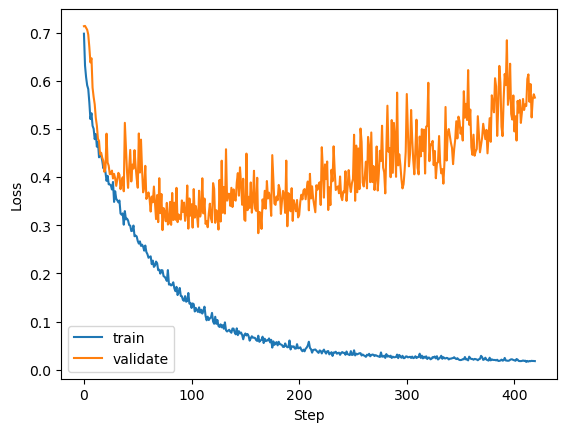

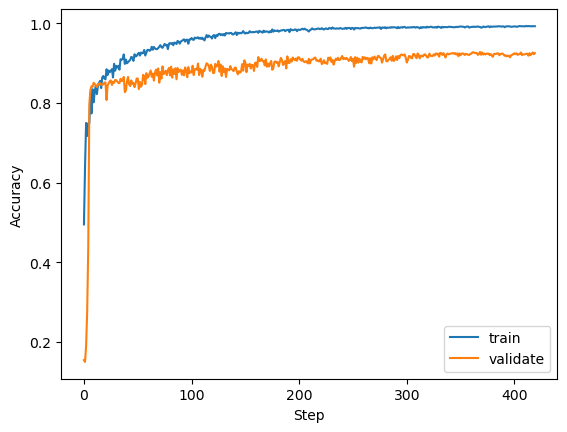

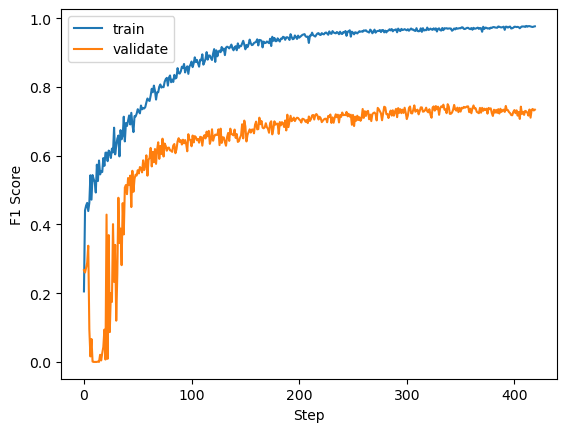

In [24]:
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validate')
plt.legend()
plt.show()

plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='validate')
plt.legend()
plt.show()

plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.plot(history['train_f1'], label='train')
plt.plot(history['val_f1'], label='validate')
plt.legend()
plt.show()

In [22]:
torch.save(best_f1_state[0], 'best_f1_state.pt')
torch.save(net.module.state_dict(), 'last_epoch_state.pt')

loss: 0.34320846 - acc: 0.96951294 - f1 score: 0.82378626


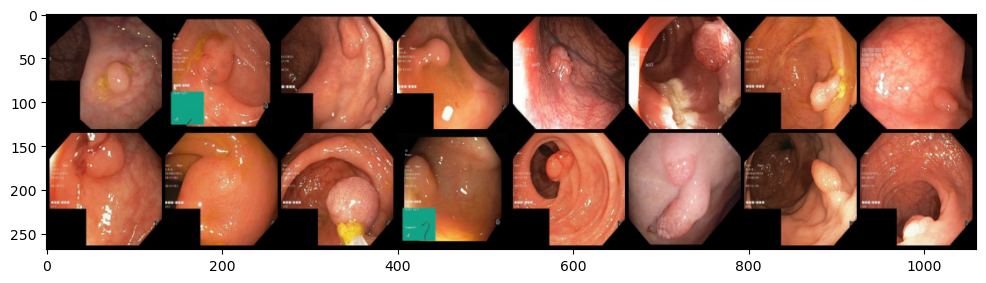

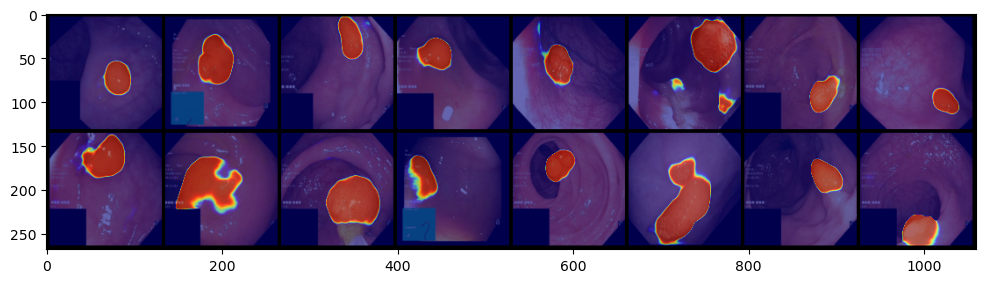

Predicted masks:


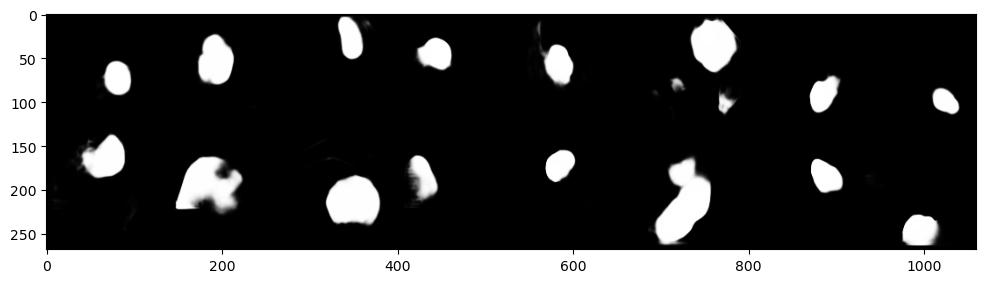

Ground truth:


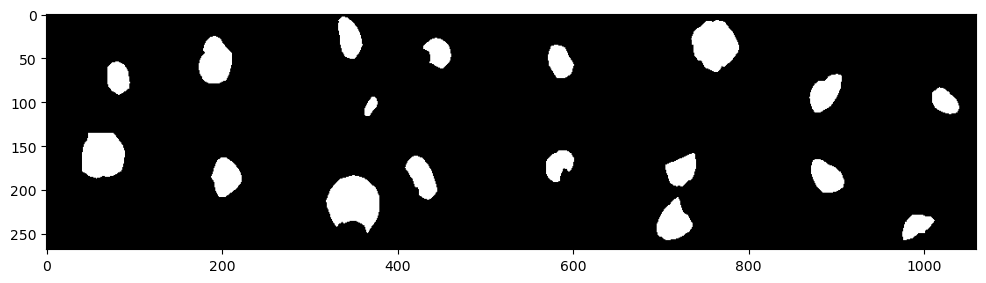

In [23]:
val_iter = iter(val_data_loader)
net.module.load_state_dict(best_f1_state[0])

images, labels = next(val_iter)
images = images.to(device)
labels = labels.to(device)
test(images, labels)